In [168]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/var/folders/tv/9n19nz5j7cq_q4j3vm06dp9w0000gn/T/ipykernel_89525/3401076300.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Functions to model a DP draw and build a sample distribution out of G.
def dp_draw(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta = base_function.rvs(1)[0]
        dp_sample.append([pi_i, sample_theta])
        remain_prob *= (1-sample_pi)
    return np.array(dp_sample, dtype=np.float64)


def dirichlet_process(alpha, base_function, k_trunc, num_samples):
    dp_samples = np.zeros((num_samples, k_trunc, 2))
    for i in range(0, num_samples):
        sample = dp_draw(alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        dp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % dp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % dp_samples.shape[1])
    print('\t Bease measure: %s' % base_function)
    return dp_samples

In [3]:
num_samples = 1000
base_function = stats.norm(loc=0., scale=3)
dp_dict = dict()

# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

k_trunc = 10000

alpha = 1000
dp_large_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples)
dp_dict[alpha] = dp_large_alpha

alpha = 100
dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples)
dp_dict[alpha] = dp_medium_alpha

alpha = 10
dp_small_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples)
dp_dict[alpha] = dp_small_alpha

DP Constructed:
	 Number of samples: 1000
	 Alpha: 10
	 Truncation value: 10000
	 Bease measure: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x156f746a0>


/var/folders/tv/9n19nz5j7cq_q4j3vm06dp9w0000gn/T/ipykernel_89525/4091572145.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)


NameError: name 'title_size' is not defined

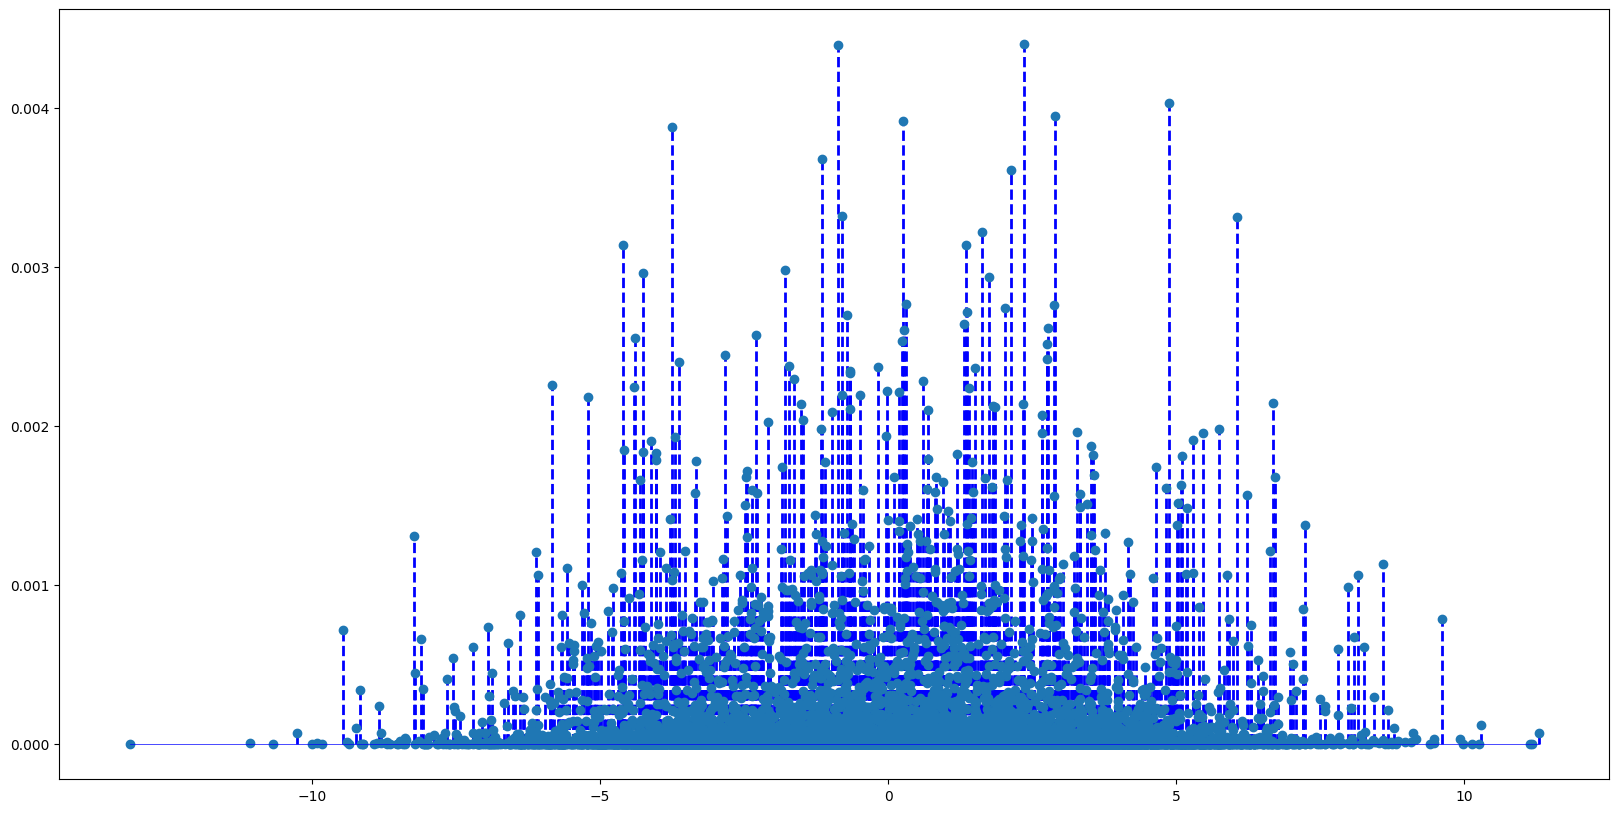

In [4]:
for alpha in dp_dict:
    dp_samples = dp_dict[alpha]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)

    ax.set_title(r'G, one draw from a DP($\alpha, H$)'+'\n'+r' $\alpha$=%s and $H=\mathcal{N}(\mu=0.,\sigma=3.)$' % alpha, size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

# Chinese restaurant process

In [6]:
def compute_cum_prob(counts, alpha):
    probs = np.array(counts)
    norm = probs.sum() + alpha
    probs = probs/norm
    probs = list(probs)
    probs.append(alpha/norm)
    
    cum = np.zeros(len(probs))
    for i in range(len(probs)):
        cum[i] = np.sum(probs[:i+1])        
    return cum

def new_customer(counts, alpha):
    unif = stats.uniform()
    u = unif.rvs(1)
    cum = compute_cum_prob(counts, alpha)
    for i, prob_c in enumerate(cum):
        if u < prob_c:
            if i == len(cum)-1:
                counts.append(1)
            else:
                counts[i] +=1
            break
    return counts

def chinese_restaurant_process(counts, alpha, n_cust):
    for j in range(n_cust):
        counts = new_customer(counts, alpha)
    return counts

Processed customer: Alpha 1 Sample 2 9786/10000


KeyboardInterrupt: 

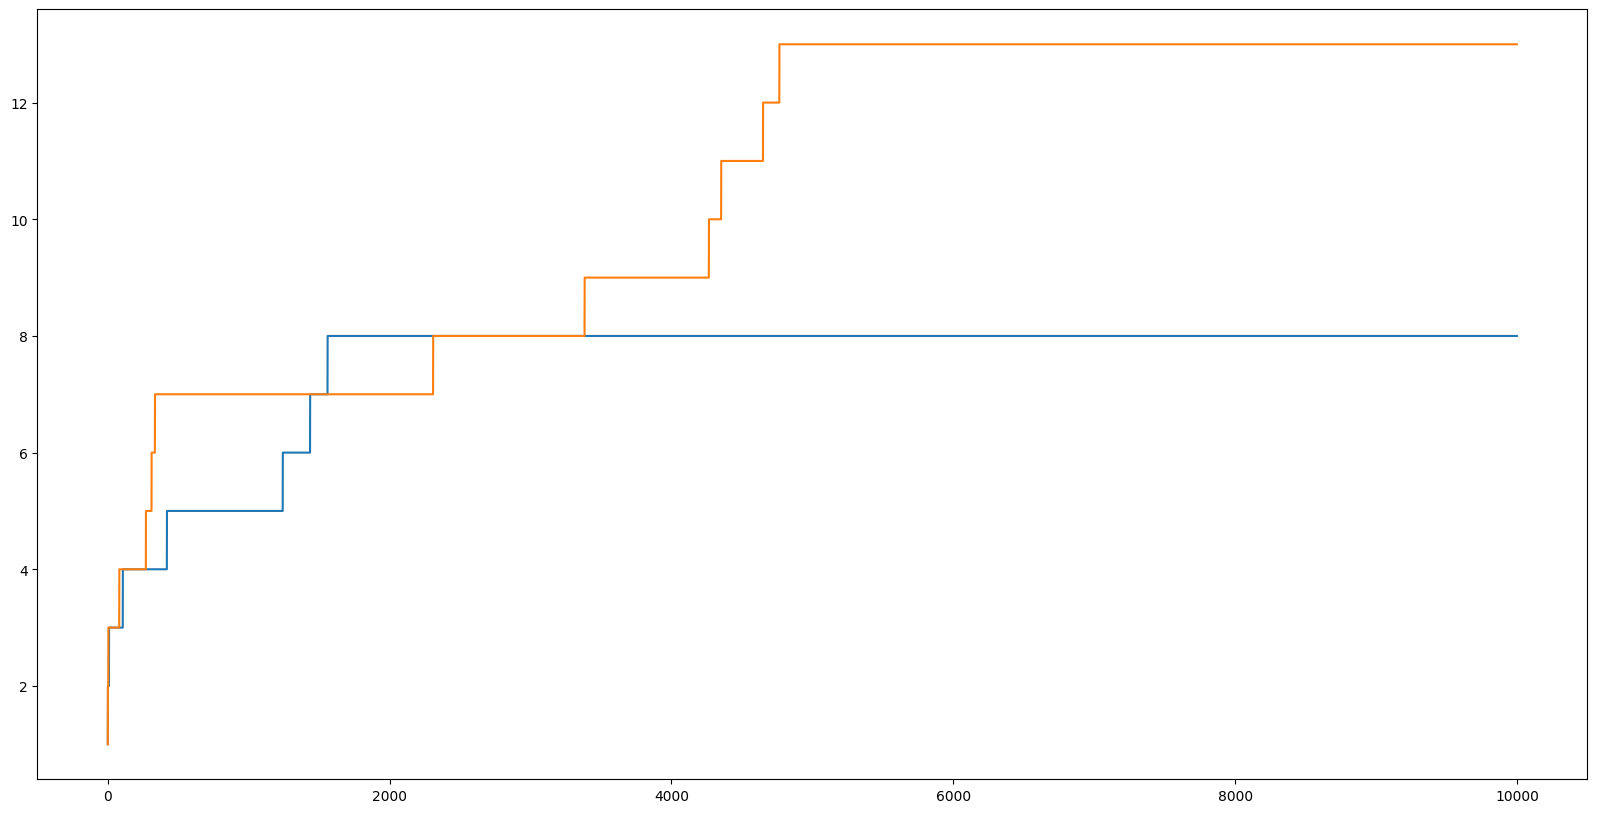

In [8]:
# Plot parameters
total_customers = 10000
samples_crp = 10

for alpha in [1, 10, 100]:
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    
    for j in range(samples_crp):
        counts = list()
        num_tables = list()
        for i in range(total_customers):
            counts = chinese_restaurant_process(counts, alpha, n_cust=1)
            num_tables.append(len(counts))
            print('Processed customer: Alpha %s Sample %s %s/%s' % (alpha, j, i+1, total_customers))
            clear_output(wait=True)
        if j != samples_crp-1:
            ax.plot(range(total_customers), num_tables)
    ax.plot(range(total_customers), num_tables, label='Sample of CRP')    
    ax.set_title(r'Samples of CRP tables/cust $\alpha=%s$' % alpha, size=title_size)
    ax.set_ylabel('Number of tables', size=axis_size)
    ax.set_xlabel('Number of customers', size=axis_size)
    ax.tick_params(labelsize=axis_size-10) 
    plt.legend(prop={'size': legend_size})
    plt.tight_layout()
    plt.savefig('images/crp/chinese_restaurant_process_tables_alpha_%s.png' % alpha, dpi=100)

In [9]:
num_tables

[1,
 2,
 2,
 3,
 3,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 

In [10]:
counts

[193, 667, 4792, 1948, 993, 279, 333, 14, 265, 238, 56, 4, 1, 3]

In [162]:
def compute_cum_prob(counts, alpha):
    probs = np.array(counts)
    norm = probs.sum() + alpha
    probs = probs / norm
    probs = list(probs)
    probs.append(alpha/norm)
    
    cum = np.zeros(len(probs))
    for i in range(len(probs)):
        cum[i] = np.sum(probs[:i+1])        
    return cum

def new_customer(counts, alpha):
    unif = stats.uniform()
    u = unif.rvs(1)
    cum = compute_cum_prob(counts, alpha)
    table_id = None
    for i, prob_c in enumerate(cum):
        if u < prob_c:
            if i == len(cum)-1:
                counts.append(1)
                table_id = len(counts) - 1
            else:
                counts[i] += 1
                table_id = i
            break
    return table_id

def chinese_restaurant_process(counts, alpha, n_cust):
    table_ids = []
    for j in range(n_cust):
        table_id = new_customer(counts, alpha)
        table_ids.append(table_id)
    return table_ids

def generate_investors_crp(m, alpha):
    table_ids = chinese_restaurant_process([], alpha, n_cust=m)
    return table_ids

In [163]:
table_ids = generate_investors_crp(100, alpha=2)

In [164]:
print(table_ids)

[0, 1, 0, 0, 2, 0, 0, 2, 2, 3, 1, 4, 1, 5, 2, 2, 0, 2, 2, 0, 2, 1, 2, 6, 2, 6, 0, 2, 2, 7, 2, 8, 2, 9, 3, 2, 3, 3, 0, 0, 0, 3, 1, 0, 2, 9, 1, 2, 1, 0, 0, 9, 2, 2, 3, 0, 2, 10, 1, 0, 2, 2, 3, 2, 0, 0, 3, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 9, 0, 0, 5, 1, 0, 1, 2, 0, 1, 0, 0, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 0]
